In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

from icepacktools import load_icepack_hist, plot_hist_var, plot_forc_var
from icepacktools import plot_ice_var, plot_handler, plot_freshwater_budget

In [5]:
# Load history output
ip_dirs_path = "/root/icepack-dirs"
run_dict = {"mos_fyi_sealvl": 'icepack.h.20191129.nc',
            "mos_fyi_sealvl_rpnd": 'icepack.h.20191129.nc',
            }

trcr_dict = {17: 'alvl',
             18: 'vlvl',}
trcrn_dict = {17: 'alvln',
              18: 'vlvln',}

hist_dict = {}
for key, value in run_dict.items():
    hist_dict[key] = load_icepack_hist(run_name=key, 
                                       icepack_dirs_path=ip_dirs_path, 
                                       hist_filename=value, pnd_budget=True,
                                       volp=True, trcr_dict=trcr_dict,
                                       trcrn_dict=trcrn_dict)

# Create ice thickness change
for value in hist_dict.values():
    value['vice_chg'] = value['vice'] - value['vice'].isel(time=0)
    value['pndaspect'] = value['hpnd'] / value['apnd']
    value['hin'] = value['vicen'] / value['aicen']

In [6]:
# Load forcing
forcing_path = os.path.join(ip_dirs_path, "input", "Icepack_data",
                            "forcing", "MOSAiC")
atm_filename = "MOSAiC_kazr_snow_MDF_20191005_20201001.nc"
ds_atm = xr.open_dataset(os.path.join(forcing_path, atm_filename))
ocn_filename = 'MOSAiC_ocn_MDF_20191006_20200919.nc'
ds_ocn = xr.open_dataset(os.path.join(forcing_path, ocn_filename))
ds_forc = xr.merge([ds_atm, ds_ocn])
# Create temp above frz
ds_forc['sst_above_frz'] = ds_forc['tos'] - ds_forc['tosf']
# mapping from Icepack names to forcing names
forc_var_map = {'flw': ['rlds'],
                'fsw': ['rsds'],
                'Tair': ['tas'],
                'Qa': ['hus'],
                'sst': ['tos'],
                'sss': ['so'],
                'Tf': ['tosf'],
                'sst_above_frz': ['sst_above_frz'],
                }

In [7]:
# Load ice properties
# Load stakes
data_path = "/root/data/mass_balance_data"
data_filename = "ablationStakes_hotwireThicknessGauges_MOSAiC.csv"
df_stak = pd.read_csv(os.path.join(data_path, data_filename), parse_dates=[3,4,7])
# We want to create a dataframe where the row index is site and date and the
# column index is stat_name, and then mean and standard error of mean.
# rename columns to make our life easier
df_renamed = df_stak.rename(columns={'Site name': 'site', 
                                     'Measurement date': 'time',
                                     'Ice thickness (calculated) (cm)': 'hi_hotwire',
                                     'Drilled ice thickness (cm)': 'hi_drill',
                                     'Snow depth (calculated) (cm)': 'hs_gauge',
                                     'Pond depth (cm)': 'hpnd',
                                     'Pond flag': 'apnd'})
# cm to m
for var_name in ['hi_hotwire', 'hi_drill', 'hs_gauge', 'hpnd']:
    df_renamed[var_name] = df_renamed[var_name]/100
stat_names = ['hi_hotwire','hi_drill','hs_gauge','hpnd','apnd']
df_ice = df_renamed.groupby(['site', 'time'])[stat_names].agg(
    ['mean', 'sem'])
# Load transect
data_path = "/root/data/transect_data_melinda"
data_filename = "leg4transect_dcs.csv"
df_tran = pd.read_csv(os.path.join(data_path, data_filename), parse_dates=[0])
df_tran.fillna(value=0, inplace=True)
df_tran['site'] = 'transect'
df_tran = df_tran.rename(columns={'Date time': 'time',
                                  'ice thickness (m)': 'hin_gems',
                                  'snow/SSL thickness (m)': 'hsn_magnaprobe',
                                  'pond fraction': 'apndn',
                                  'pond depth (m)': 'hpndn',
                                  'ice thickness category': 'category'})
df_tran.set_index(['site', 'time', 'category'], inplace=True)
df_agg = df_tran[['hin_gems', 'hsn_magnaprobe', 'apndn', 'hpndn']].mul(
    df_tran['aicen'], axis=0).groupby(level=[0, 1]).agg('sum')
df_agg = df_agg.rename(columns={'hin_gems': 'hi_gems',
                                'hsn_magnaprobe': 'hs_magnaprobe',
                                'apndn': 'apnd',
                                'hpndn': 'hpnd'})
df_sem = df_agg.copy()
df_sem.values[:,:] = np.nan
#df_agg = pd.concat([df_agg], axis=1, keys=['mean']).swaplevel(0, 1, 1)
#df_sem = pd.concat([df_sem], axis=1, keys=['sem']).swaplevel(0, 1, 1)
df_agg = pd.concat([df_agg, df_sem], axis=1, keys=['mean', 'sem']
                   ).reorder_levels([1, 0], axis=1).sort_index(axis=1)
df_ice = pd.concat([df_ice, df_agg], axis=0)

ice_var_map = {'vice': ['hi_hotwire', 'hi_drill', 'hi_gems'],
               'vsno': ['hs_gauge', 'hs_magnaprobe'],
               'hpnd': ['hpnd'],
               'apnd': ['apnd'],
               'hin': ['hin_gems'],
               'hpndn': ['hpndn'],
               'apndn': ['apndn'],
               'aicen': ['aicen']
               }


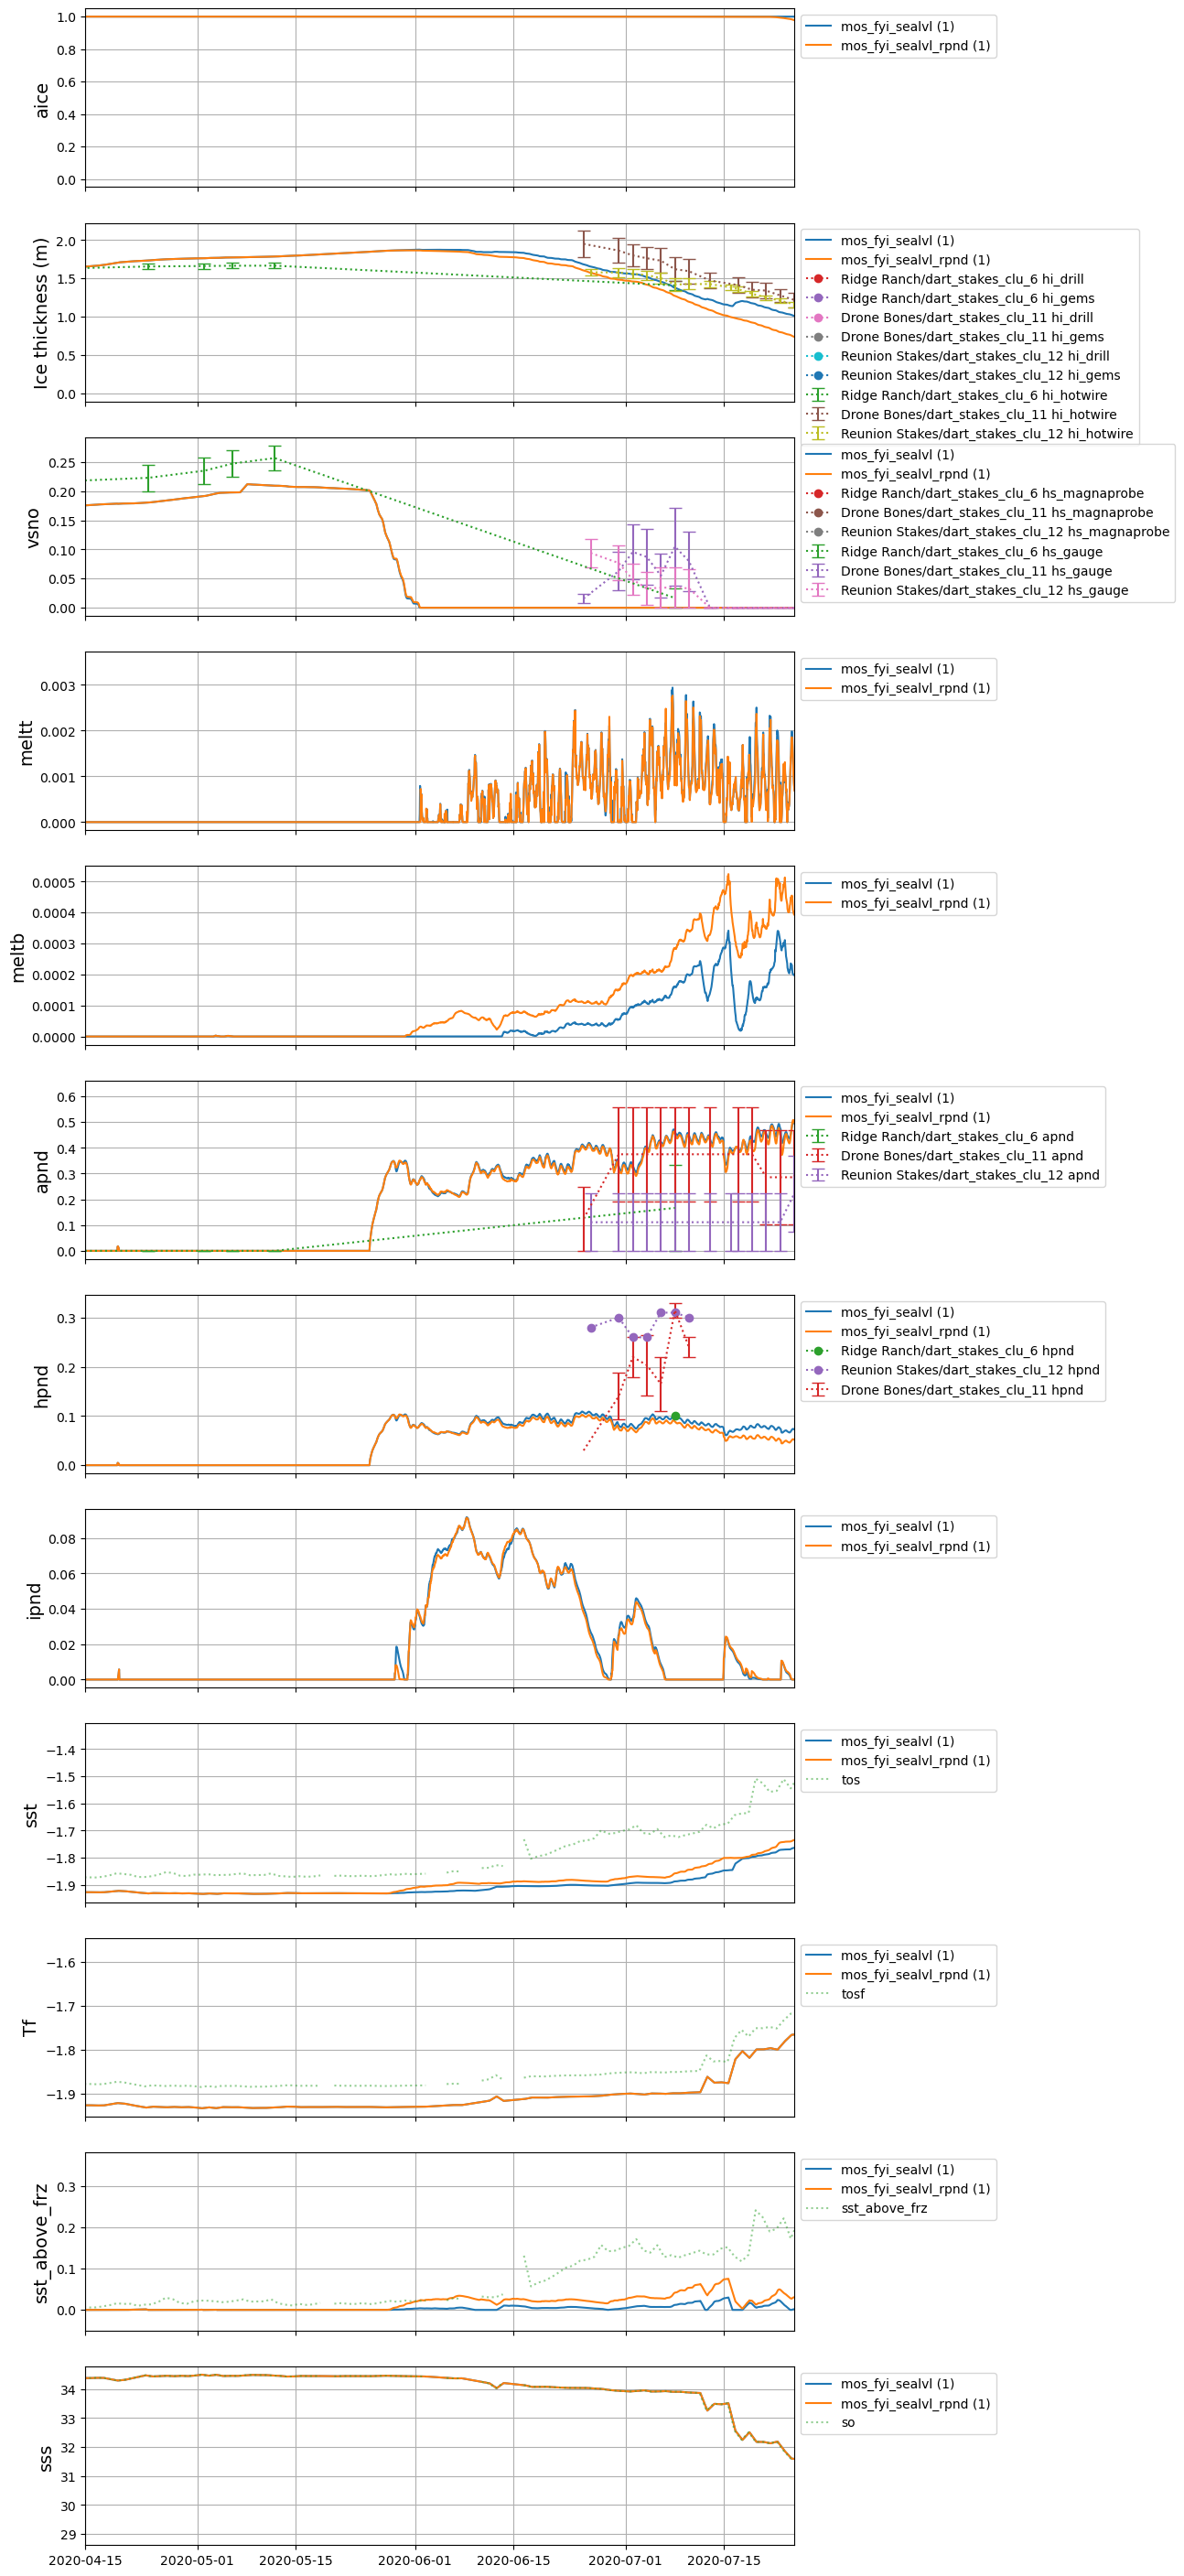

In [14]:
# Validate Simulation
run_plot_dict = {"mos_fyi_sealvl": [1],
                "mos_fyi_sealvl_rpnd": [1],}
var_names = ['aice', 'vice', 'vsno', 
             'meltt', 'meltb',
             'apnd', 'hpnd', 'ipnd',
             'sst', 'Tf', 'sst_above_frz', 'sss',
             ]
ice_sites = ['Ridge Ranch/dart_stakes_clu_6',
             'Drone Bones/dart_stakes_clu_11',
             'Reunion Stakes/dart_stakes_clu_12',
             ]
xlim = [datetime.datetime.fromisoformat('2020-04-15'),
        datetime.datetime.fromisoformat('2020-07-25')]
f, axs = plot_handler(run_plot_dict, var_names, hist_dict,
                 forc_var_map=forc_var_map,
                 ice_var_map=ice_var_map,
                 ds_forc=ds_forc, df_ice=df_ice, xlim=xlim,
                 ice_sites=ice_sites, mean_only=False,)
axs[1].set_ylabel('Ice thickness (m)')
plt.show()

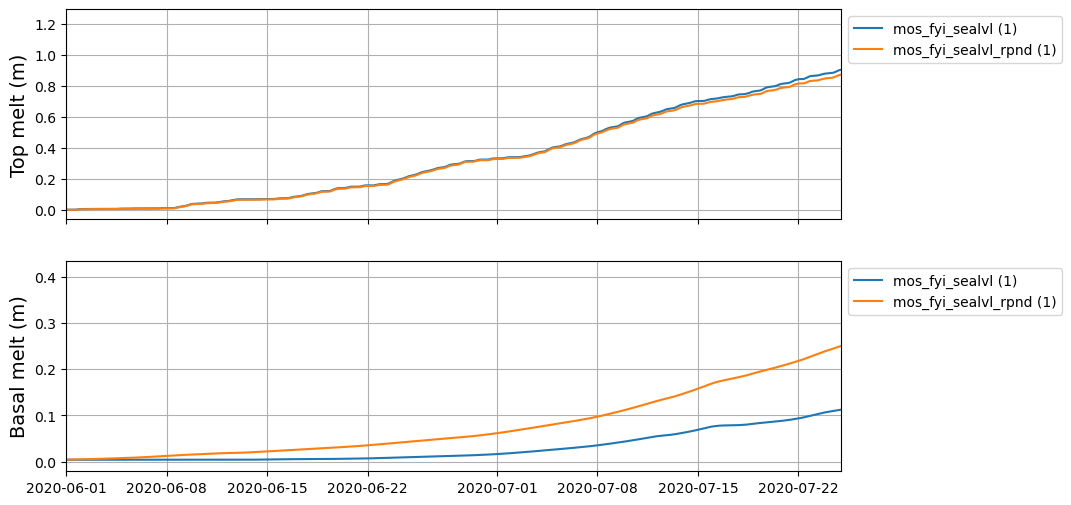

In [16]:
# Validate Simulation
run_plot_dict = {"mos_fyi_sealvl": [1],
                "mos_fyi_sealvl_rpnd": [1],}
var_names = ['meltt', 'meltb',
             ]
xlim = [datetime.datetime.fromisoformat('2020-06-01'),
        datetime.datetime.fromisoformat('2020-07-25')]
f, axs = plot_handler(run_plot_dict, var_names, hist_dict,
                 cumulative=True, xlim=xlim)

axs[0].set_ylabel('Top melt (m)')
axs[1].set_ylabel('Basal melt (m)')
plt.show()

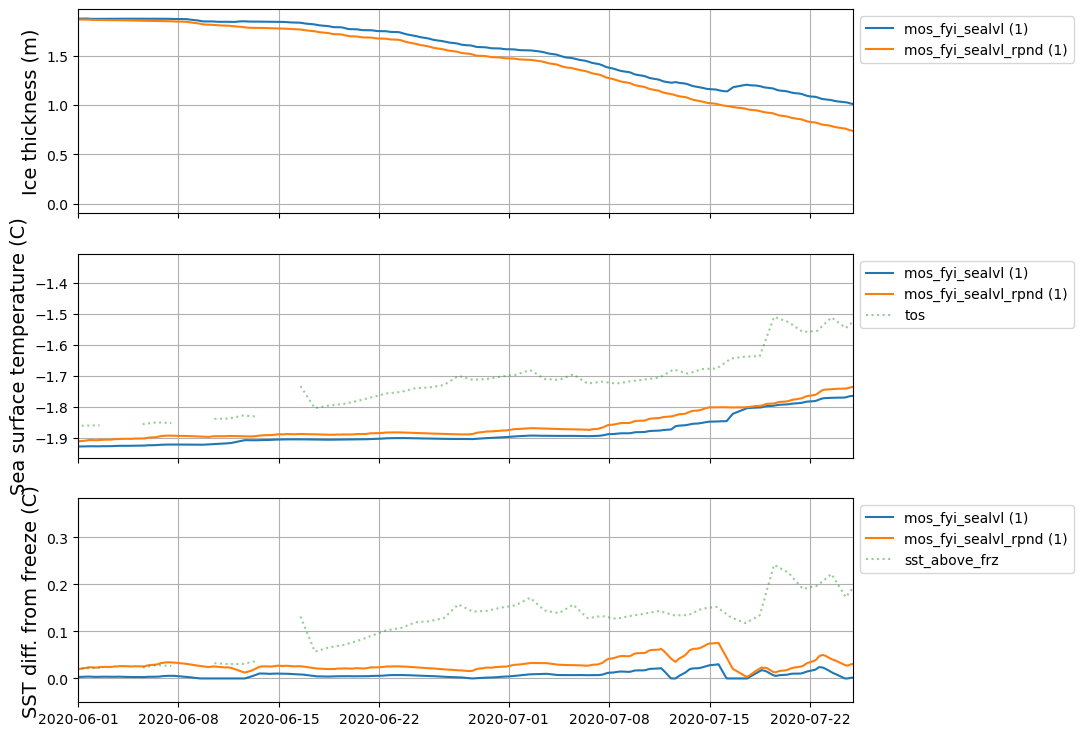

In [21]:
# Validate Simulation
run_plot_dict = {"mos_fyi_sealvl": [1],
                "mos_fyi_sealvl_rpnd": [1],}
var_names = ['vice', 
             'sst', 'sst_above_frz',
             ]
xlim = [datetime.datetime.fromisoformat('2020-06-01'),
        datetime.datetime.fromisoformat('2020-07-25')]
f, axs = plot_handler(run_plot_dict, var_names, hist_dict,
                 forc_var_map=forc_var_map,
                 ds_forc=ds_forc, df_ice=df_ice, xlim=xlim,
                 )
axs[0].set_ylabel('Ice thickness (m)')
axs[1].set_ylabel('Sea surface temperature (C)')
axs[2].set_ylabel('SST diff. from freeze (C)')
plt.show()